In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [4]:
elec_data = pd.read_csv("../data/electrification.csv")

In [5]:
sp.stats.pearsonr(elec_data["daily_exp"], elec_data["electrification"])

(0.24690479704323848, 0.0)

In [372]:
df = pd.read_csv("../results/fold_28/test_results.csv")

In [373]:
#df = pd.read_csv("../results/fold_india/test_results.csv")

In [374]:
print(df["state_name"][0])

Uttarakhand


In [375]:
df = df.merge(elec_data, how="inner", left_on="id", right_on="village_id")

In [376]:
df = df.loc[:,("smoothed", "true", "lat", "lng", "taluk_idx", "district_idx", "state_idx", "state_name", 
               "electrification", "pop")]
df = df.rename(columns={"smoothed": "pred"})

In [377]:
sp.stats.pearsonr(df["pred"], df["true"])[0]

0.18217514107047172

In [378]:
print("Length of merged test set: %d" % len(df))

Length of merged test set: 14130


In [379]:
vmin = np.min(np.r_[df["true"], df["pred"]])
vmax = np.max(np.r_[df["true"], df["pred"]])

Text(0.5, 1.0, 'Predicted Expenditure')

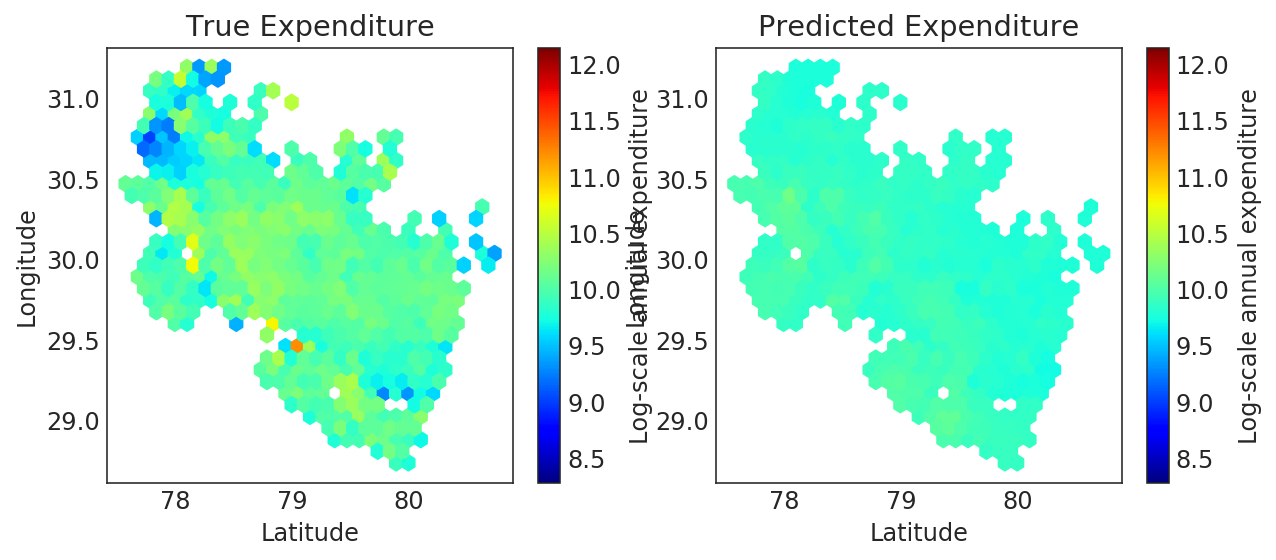

In [380]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], C=df["true"], gridsize=30, cmap=mpl.cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("True Expenditure")
plt.subplot(1,2,2)
plt.hexbin(df["lng"], df["lat"], C=df["pred"], gridsize=30, cmap=mpl.cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted Expenditure")

In [381]:
#df.to_csv("../results/fold_india/effect_estimation_df.csv")

#### How well does satellite imagery predict treatment effects?

See R code.

#### Conjugate Linear Regression

Note that the correlation coefficient is equivalent to performing regression on standardized outcome and covariate.

In [382]:
df["x_normed"] = (df["electrification"] - np.mean(df["electrification"])) / np.std(df["electrification"])
df["y_normed"] = (df["true"] - np.mean(df["true"])) / np.std(df["true"])

In [383]:
true_cor = sp.stats.pearsonr(df["true"], df["electrification"])[0]

In [384]:
pred_cor = sp.stats.pearsonr(df["pred"], df["electrification"])[0]

In [400]:
sigmasq_hat = 0.9236921
# sigmasq_hat = 0.5

In [401]:
pm = sp.stats.pearsonr(df["pred"], df["electrification"])[0]
pv = np.sqrt(0.1) / sigmasq_hat

In [402]:
class ConjugateLinearModel(object):
  
  def __init__(self, pm, pv, sigmasq_hat):
    self.pm = pm
    self.pv = pv
    self.sigmasq_hat = sigmasq_hat
    
  def fit(self, x, y):
    mu = self.pm - 1 / (np.dot(x, x) + 1 / self.pv) * (np.dot(x, x) * self.pm - np.dot(x, y))
    sig = self.sigmasq_hat * 1 / (1 / self.pv + np.dot(x, x))
    return mu, sig

In [403]:
idx = np.arange(len(df))

In [404]:
np.random.shuffle(idx)

In [405]:
n_samples = 500

In [406]:
model = ConjugateLinearModel(pm, pv, sigmasq_hat)

In [407]:
mus = np.zeros(n_samples)
sigs = np.zeros(n_samples)

In [408]:
for i in range(n_samples):
  y = df.loc[idx[:i], "y_normed"]
  x = df.loc[idx[:i], "x_normed"]
  mu, sig = model.fit(x, y)
  mus[i] = mu
  sigs[i] = sig

(-1, 1)

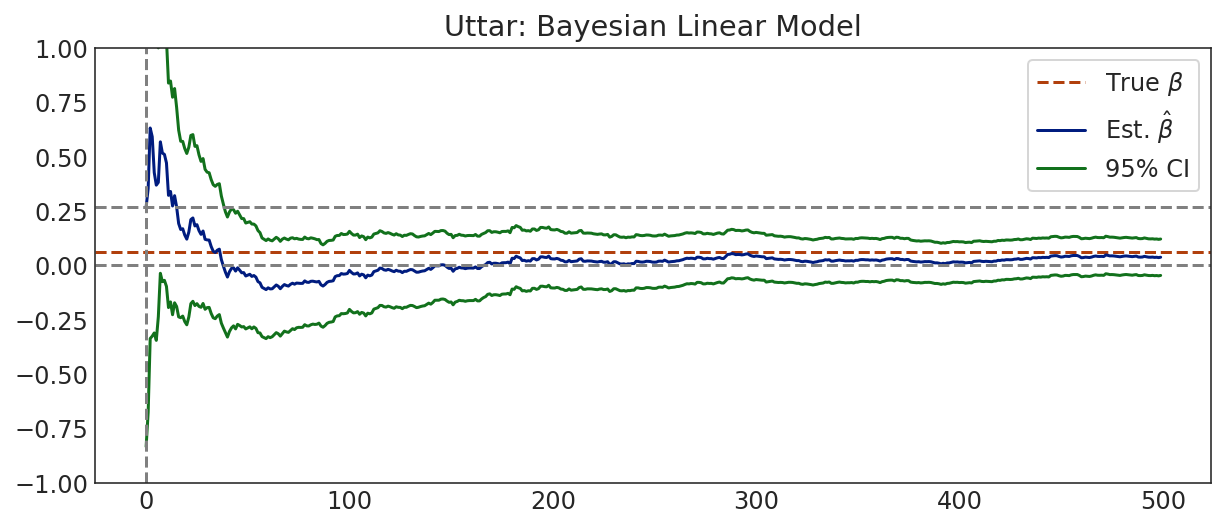

In [409]:
plt.figure(figsize = (10, 4))
plt.axhline(true_cor, linestyle="--", color = plt_colors[1], label = "True $\\beta$")
plt.plot(mus, color = plt_colors[0], label = "Est. $\\hat\\beta$")
plt.plot(mus - 1.96 * np.sqrt(sigs), color = plt_colors[2])
plt.plot(mus + 1.96 * np.sqrt(sigs), color = plt_colors[2], label = "95% CI")
plt.axhline(pred_cor, linestyle="--", color = "grey")
plt.axhline(0, linestyle="--", color="grey")
plt.axvline(np.argmax(mus - 1.96 * np.sqrt(sigs) > 0), linestyle="--", color="grey")
plt.legend()
plt.title("Uttar: Bayesian Linear Model")
plt.ylim(-1,1)

In [410]:
np.argmax(mus - 1.96 * np.sqrt(sigs) > 0)

0

In [411]:
mus = np.zeros(n_samples)
sigs = np.zeros(n_samples)

In [412]:
for i in range(1, n_samples):
  y = df.loc[idx[:i], "y_normed"]
  x = df.loc[idx[:i], "x_normed"]
  mu = 1 / np.dot(x, x) * np.dot(x, y)
  if i > 20:
    sig = np.dot(y - x * mu, y - x * mu) / len(x) / np.dot(x, x) 
  else:
    sig = 0.3
  mus[i-1] = mu
  sigs[i-1] = sig

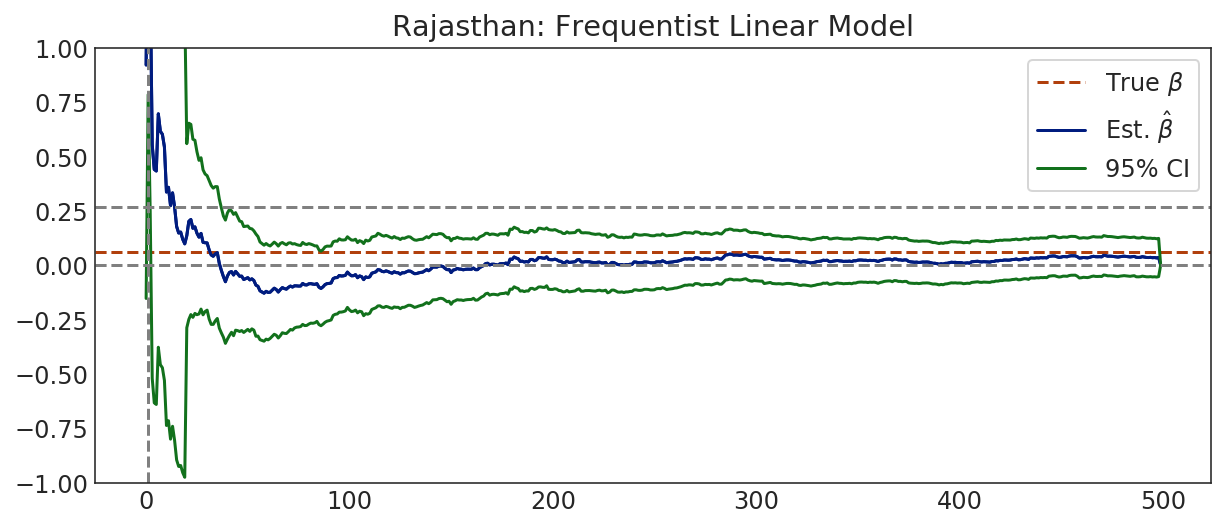

In [413]:
plt.figure(figsize = (10, 4))
plt.plot(mus)
plt.axhline(true_cor, linestyle="--", color = plt_colors[1], label = "True $\\beta$")
plt.plot(mus, color = plt_colors[0], label = "Est. $\\hat\\beta$")
plt.plot(mus - 1.96 * np.sqrt(sigs), color = plt_colors[2])
plt.plot(mus + 1.96 * np.sqrt(sigs), color = plt_colors[2], label = "95% CI")
plt.axhline(0, linestyle="--", color="grey")
plt.axhline(pred_cor, linestyle="--", color = "grey")
plt.axvline(np.argmax(mus - 1.96 * np.sqrt(sigs) > 0), linestyle="--", color="grey")
plt.ylim(-1,1)
plt.title("Rajasthan: Frequentist Linear Model")
plt.legend()

In [331]:
np.argmax(mus - 1.96 * np.sqrt(sigs) > 0)

3